### Loading the image data into a dict and saving it to a pickle file:

In [24]:
import os
import joblib
from skimage.io import imread
from skimage.transform import resize
 
def resize_all(sourcedir, includedirs, width=80, height=80, filename="animals"):
    """
    load images from path, resize them and write them as arrays to a dictionary,
    together with labels and metadata. The dictionary is written to a pickle file
    named '{pklname}_{width}x{height}px.pkl'.
     
    Parameter
    ---------
    sourcedir: str
        path to parent folder of data
    width: int
        target width of the image in pixels
    height: int
        target height of the image in pixels
    includedirs: set[str]
        set of data folders (e.g 'BearHead')
    """
 
    data = dict()
    data['description'] = 'resized ({0}x{1})animal images in rgb'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []
    
    for folder in os.listdir(sourcedir):
        if folder in includedirs:
            for file in os.listdir(sourcedir+"/"+folder):
                #print("file: " ,file)
                data['label'].append(folder)
                data['filename'].append(file)
                imgfile = imread(sourcedir+"/"+folder+"/"+file)
                img = resize(imgfile, (width, height))
                data['data'].append(img)
    joblib.dump(data, filename+ ('_{0}x{1}px.pkl'.format(int(width), int(height))) )


### Reloading the pickle file and displaying basic stats:

In [2]:
animals = ['BearHead', 'ChickenHead', 'CowHead', 'DeerHead', 'DuckHead', 'ElephantHead', 'LionHead', 'MonkeyHead']

In [3]:
resize_all('./Image', animals)

In [4]:
import numpy as np
 
data = joblib.load('animals_80x80px.pkl')
 
print('number of pictures: ', len(data['filename']))
print('image size: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))


number of pictures:  812
image size:  (80, 80, 3)
labels: ['BearHead' 'ChickenHead' 'CowHead' 'DeerHead' 'DuckHead' 'ElephantHead'
 'LionHead' 'MonkeyHead']


### Displaying the first picture of each label:

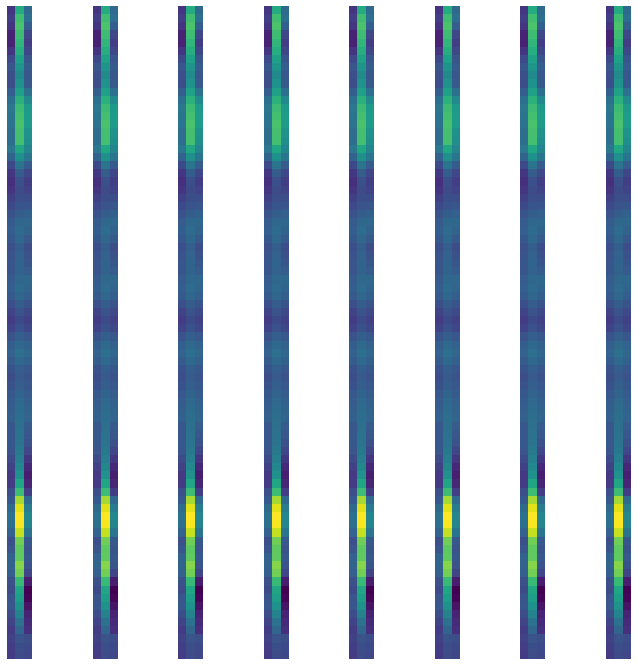

In [5]:
import matplotlib.pyplot as plt 

fig, axs = plt.subplots(1, 8, figsize=(12, 12))

for i, d in enumerate(np.unique(data['label'])):
    axs[i].imshow(data['data'][data['label'] == d][0])
    axs[i].axis('off')

Kapernikov to the rescue:

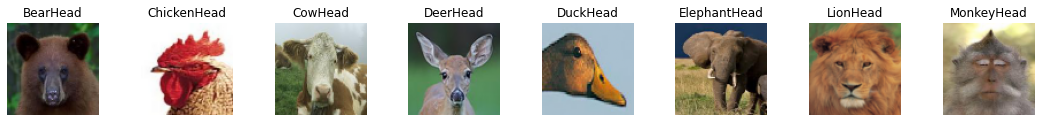

In [6]:
labels = np.unique(data['label'])
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

### Separating the data into X and y, and creating the train/test split (with shuffling):

In [7]:
# Note: if the picture set contains GIF images, this will poison the dataset,
# and np.array() will fail on a ValueError.
X = np.array(data['data'])
y = np.array(data['label'])

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, shuffle=True)

### Checking that 'shuffle=True' did evenly split across all animals:

In [9]:
from collections import Counter

Counter(y_train)

Counter({'BearHead': 81,
         'MonkeyHead': 86,
         'DuckHead': 85,
         'LionHead': 80,
         'DeerHead': 87,
         'ElephantHead': 79,
         'ChickenHead': 69,
         'CowHead': 82})

In [10]:
Counter(y_test)

Counter({'LionHead': 22,
         'ElephantHead': 21,
         'BearHead': 20,
         'ChickenHead': 31,
         'CowHead': 21,
         'DeerHead': 16,
         'MonkeyHead': 14,
         'DuckHead': 18})

### Preprocessing (RGB2Gray + HOG Transformer):

In [11]:
from skimage.feature import hog
from skimage.transform import rescale
from sklearn.base import BaseEstimator, TransformerMixin
import skimage.color

class GreyHogTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, 
                 y=None, 
                 orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), 
                 block_norm='L2-Hys'):
        
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y):
        return self
 
    def transform(self, X, y=None):
        return np.array([hog(skimage.color.rgb2gray(img)
                             , orientations= self.orientations
                             , pixels_per_cell= self.pixels_per_cell
                             , cells_per_block= self.cells_per_block
                             , block_norm= self.block_norm
                            ) 
                         for img in X])
        

In [12]:
from sklearn.preprocessing import StandardScaler

greyhog = GreyHogTransformer()
scaler = StandardScaler()

preproc = greyhog.transform(X_train)
preproc = scaler.fit_transform(preproc)


labels = np.unique(data['label'])
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

### Stochastic Gradient Descent (SGD) classifier:

In [13]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(random_state=0)
sgd.fit(preproc, y_train)


SGDClassifier(random_state=0)

In [14]:
preproctest = greyhog.transform(X_test)
preproctest = scaler.fit_transform(preproctest)

y_pred = sgd.predict(preproctest)
print('Correct percentage: ', 100*np.sum(y_pred == y_test)/len(y_test))

Correct percentage:  81.59509202453988


### Confusion Matrix:

In [15]:
from sklearn.metrics import confusion_matrix

confmx = confusion_matrix(y_test, y_pred)
confmx

array([[18,  0,  0,  2,  0,  0,  0,  0],
       [ 0, 27,  1,  2,  1,  0,  0,  0],
       [ 0,  0, 16,  3,  1,  1,  0,  0],
       [ 0,  0,  0, 16,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 18,  0,  0,  0],
       [ 1,  0,  0,  0,  3, 16,  0,  1],
       [ 1,  0,  1,  2,  0,  2, 15,  1],
       [ 2,  1,  1,  1,  1,  1,  0,  7]])

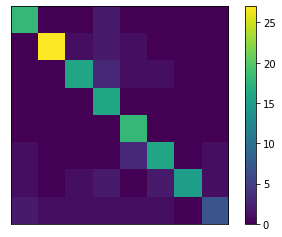

In [16]:
plt.imshow(confmx)
plt.xticks([])
plt.yticks([])
plt.colorbar();

### Pipeline creation

In [17]:
from sklearn.pipeline import Pipeline
from sklearn import svm
 
Hogpipeline = Pipeline([
    ('greyhog', GreyHogTransformer()),
    ('scaler', StandardScaler()),
    ('classifier', SGDClassifier(random_state=0))
])
 
clf = Hogpipeline.fit(X_train, y_train)
print('Percentage correct: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))

Percentage correct:  83.43558282208589


### GridSearchCV

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

parametersgrid = [
    {
        'greyhog__orientations': [8],
        'greyhog__cells_per_block': [(2, 2), (3, 3)],
        'greyhog__pixels_per_cell': [(8, 8), (10, 10), (12, 12)],
        'classifier': [
             SGDClassifier(random_state=42, max_iter=1000, tol=1e-3),
             svm.SVC(kernel='linear')
         ]
    },
    {
        'greyhog__orientations': [8, 9],
        'greyhog__cells_per_block': [(2, 2), (3, 3)],
        'greyhog__pixels_per_cell': [(8, 8), (10, 10), (12, 12)],
        'classifier': [
#              SGDClassifier(random_state=42, max_iter=1000, tol=1e-3),
             GaussianNB()
         ]
    }
]

gridsearch = GridSearchCV(Hogpipeline, 
                           parametersgrid, 
                           scoring='accuracy',
                           cv=5,
                           n_jobs=-1,
                           verbose=1,
                           return_train_score=True)
 
gridresult = gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  5.2min finished


In [19]:
gridresult.best_estimator_

Pipeline(steps=[('greyhog', GreyHogTransformer(orientations=8)),
                ('scaler', StandardScaler()),
                ('classifier', SVC(kernel='linear'))])

We can observe that the SVM classifier offers the best performance.

In [20]:
gridresult.best_score_

0.8875491949910556

In [21]:
best_pred = gridresult.predict(X_test)
print('Correct percent on X_test: ', 100*np.sum(best_pred == y_test)/len(y_test))

Correct percent on X_test:  90.1840490797546


### Saving the results using Pickle

In [22]:
joblib.dump(gridresult, 'gridsearch_result.pkl')

['gridsearch_result.pkl']

### Using a custom image set

In [25]:
animals2 = ['BearHead', 'CowHead', 'DuckHead']
resize_all('./images2', animals, filename="animals2")

data2 = joblib.load('animals2_80x80px.pkl')
 
print('number of pictures: ', len(data2['filename']))
print('image size: ', data2['data'][0].shape)
print('labels:', np.unique(data2['label']))

number of pictures:  15
image size:  (80, 80, 3)
labels: ['BearHead' 'CowHead' 'DuckHead']


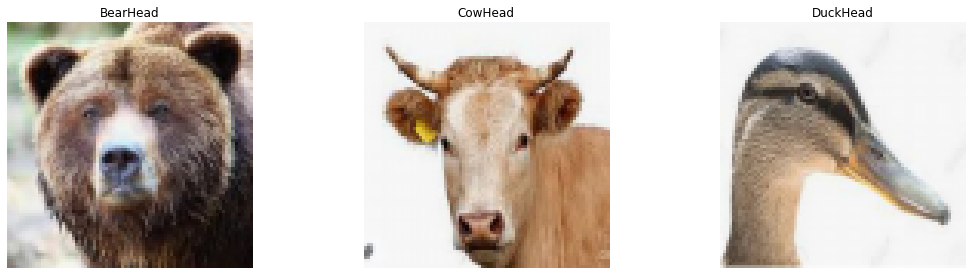

In [27]:
labels2 = np.unique(data2['label'])
fig, axes = plt.subplots(1, len(labels2))
fig.set_size_inches(15,4)
fig.tight_layout()
for ax, label in zip(axes, labels2):
    idx = data2['label'].index(label)
    ax.imshow(data2['data'][idx])
    ax.axis('off')
    ax.set_title(label)

In [29]:
X2 = np.array(data2['data'])
y2 = np.array(data2['label'])

preproc2 = greyhog.transform(X2)
preproc2 = scaler.transform(preproc2)
y_pred2 = sgd.predict(preproc2)
y_pred2

array(['BearHead', 'BearHead', 'LionHead', 'DuckHead', 'DuckHead',
       'DuckHead', 'DuckHead', 'DuckHead', 'MonkeyHead', 'ChickenHead',
       'CowHead', 'CowHead', 'CowHead', 'CowHead', 'DuckHead'],
      dtype='<U12')

Not great. Not catastrophically bad, but not great.

In [32]:
print('Correct percentage using SGD: ', 100*np.sum(y_pred2 == y2)/len(y2))

best_pred2 = gridresult.predict(X2)
print('Correct percent using SVM: ', 100*np.sum(best_pred2 == y2)/len(y2))

Correct percentage using SGD:  60.0
Correct percent using SVM:  66.66666666666667


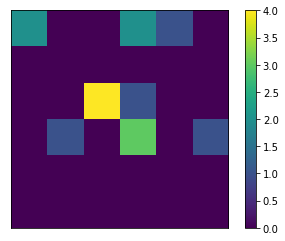

In [31]:
confmx2 = confusion_matrix(y2, y_pred2)
plt.imshow(confmx2)
plt.xticks([])
plt.yticks([])
plt.colorbar();

labels2 = np.unique(data2['label'])
fig, axes = plt.subplots(1, len(labels2))
fig.set_size_inches(15,4)
fig.tight_layout()
for ax, label in zip(axes, labels2):
    idx = data2['label'].index(label)
    ax.imshow(data2['data'][idx])
    ax.axis('off')
    ax.set_title(label)

ValueError: 'LionHead' is not in list

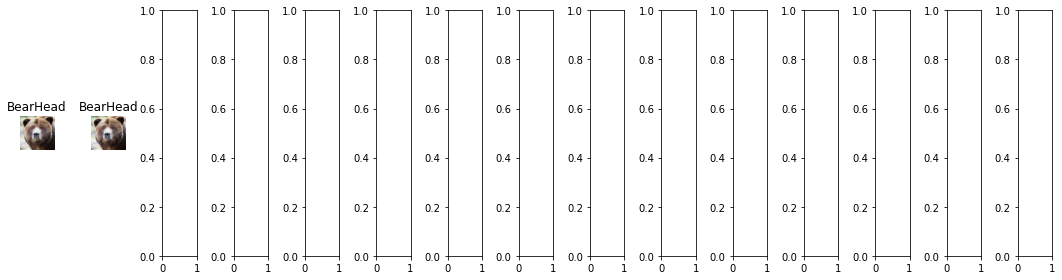

In [43]:
labels2 = y_pred2
fig, axes = plt.subplots(1, len(labels2))
fig.set_size_inches(15,4)
fig.tight_layout()
for ax, label in zip(axes, labels2):
    idx = data2['label'].index(label)
    ax.imshow(data2['data'][idx])
    ax.axis('off')
    ax.set_title(label)